In [190]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import os

In [191]:
# Define data transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        # transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [192]:
data_dir = 'data/Cars'
image_datasets = {x: datasets.ImageFolder(root=f"{data_dir}/{x}", transform=data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(class_names)
# Print some information about the datasets
print(f"Number of samples: {dataset_sizes}")
print(f"Classes: {class_names}")

['black', 'white']
Number of samples: {'train': 44, 'val': 11}
Classes: ['black', 'white']


In [194]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, len(class_names))
model.fc = nn.Linear(num_ftrs, 2)

In [195]:
# Load the pre-trained model with freezing
model = models.resnet18(pretrained=True)

# Freeze all the parameters in the network
for param in model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Ensure the parameters of the new layer are set to require gradients
for param in model.fc.parameters():
    param.requires_grad = True

In [196]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-3, momentum=0.9)

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [197]:
import copy


def train_model(model, criterion, optimizer, num_epochs=15, patience=5):
    model = model.to(device)
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = float('inf')
    no_improve_epochs = 0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if best performance
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                no_improve_epochs = 0
            elif phase == 'val':
                no_improve_epochs += 1

        # Early stopping
        if no_improve_epochs >= patience:
            print(f'Early stopping triggered after epoch {epoch}')
            break

    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


# Usage
model = train_model(model, criterion, optimizer, num_epochs=30, patience=5)

Epoch 0/29
----------
train Loss: 1.4746 Acc: 0.4545
val Loss: 0.7353 Acc: 0.6364
Epoch 1/29
----------
train Loss: 1.8101 Acc: 0.5682
val Loss: 0.9016 Acc: 0.7273
Epoch 2/29
----------
train Loss: 2.3028 Acc: 0.5682
val Loss: 1.2667 Acc: 0.5455
Epoch 3/29
----------
train Loss: 0.3909 Acc: 0.8864
val Loss: 2.5708 Acc: 0.5455
Epoch 4/29
----------
train Loss: 0.9250 Acc: 0.7500
val Loss: 1.3636 Acc: 0.6364
Epoch 5/29
----------
train Loss: 1.6386 Acc: 0.7045
val Loss: 0.1649 Acc: 0.9091
Epoch 6/29
----------
train Loss: 2.5070 Acc: 0.7500
val Loss: 1.5644 Acc: 0.9091
Epoch 7/29
----------
train Loss: 2.0110 Acc: 0.7045
val Loss: 3.7650 Acc: 0.7273
Epoch 8/29
----------
train Loss: 1.1720 Acc: 0.8636
val Loss: 1.7726 Acc: 0.9091
Epoch 9/29
----------
train Loss: 2.8521 Acc: 0.7045
val Loss: 5.2482 Acc: 0.7273
Epoch 10/29
----------
train Loss: 5.1688 Acc: 0.6818
val Loss: 2.2730 Acc: 0.6364
Early stopping triggered after epoch 10
Best val Loss: 0.164917


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = train_model(model, criterion, optimizer, num_epochs=15)

In [198]:
torch.save(model.state_dict(), 'car_classifier07.pth')

In [199]:
#test the model with unseen images
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model.load_state_dict(torch.load('car_classifier05.pth', weights_only=False))
model.eval()
model = model.to(device)

C:\Users\user\.conda\envs\pytorch_01\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [200]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [201]:
from PIL import Image

def process_image(image_path):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image.to(device)

In [202]:
def predict(image_path):
    image = process_image(image_path)
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    return class_names[predicted.item()]

In [203]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_metrics():
    true_labels = []
    predicted_labels = []
    
    for label in ['black', 'white']:
        folder_path = os.path.join('data/Cars/testset/', label)
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.jpeg')):
                file_path = os.path.join(folder_path, filename)
                prediction = predict(file_path)
                
                true_labels.append(label)
                predicted_labels.append(prediction)
                
                print(f'File: {file_path}, True: {label}, Predicted: {prediction}')
    
    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=['black', 'white'])
    
    # Extract TP, FP, TN, FN
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print("\nConfusion Matrix:")
    print(cm)
    print(f"\nTrue Positives (TP): {tp}")
    print(f"False Positives (FP): {fp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Negatives (FN): {fn}")
    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")
    
    # Detailed classification report
    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels))
    
    
     # Visualizations
    plt.figure(figsize=(12, 5))
    
    # Confusion Matrix Heatmap
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # Metrics Bar Plot
    plt.subplot(1, 2, 2)
    metrics = [accuracy, precision, recall, f1_score]
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    sns.barplot(x=metric_names, y=metrics)
    plt.title('Model Performance Metrics')
    plt.ylim(0, 1)
    for i, v in enumerate(metrics):
        plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
# Run the evaluation

File: data/Cars/testset/black\0000006_01111_d_00000035.jpg, True: black, Predicted: black
File: data/Cars/testset/black\0000006_01111_d_00000037.jpg, True: black, Predicted: black
File: data/Cars/testset/black\0000006_02138_d_00000063.jpg, True: black, Predicted: black
File: data/Cars/testset/black\0000353_02500_d_000019327.jpg, True: black, Predicted: black
File: data/Cars/testset/black\bc01.jpg, True: black, Predicted: black
File: data/Cars/testset/black\bc02.jpg, True: black, Predicted: black
File: data/Cars/testset/black\bc03.jpg, True: black, Predicted: white
File: data/Cars/testset/black\bc04.jpg, True: black, Predicted: black
File: data/Cars/testset/black\bc05.jpg, True: black, Predicted: black
File: data/Cars/testset/black\bc06.jpg, True: black, Predicted: black
File: data/Cars/testset/black\bc07.jpg, True: black, Predicted: black
File: data/Cars/testset/black\bc08.jpg, True: black, Predicted: black
File: data/Cars/testset/black\bc09.jpg, True: black, Predicted: black
File: dat

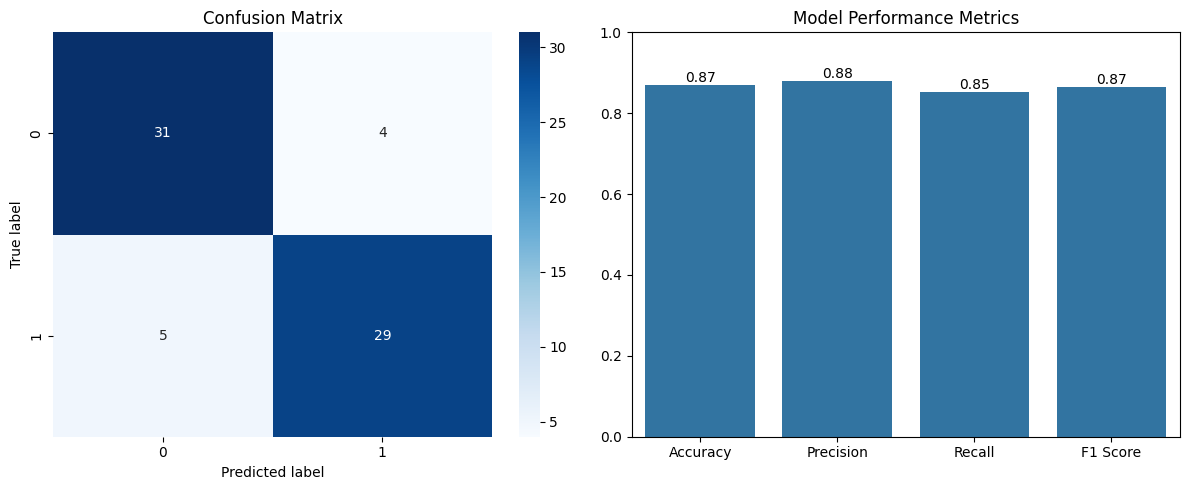

In [204]:
# Run the evaluation
calculate_metrics()

In [157]:
def trueOrFalse(output, label):
    if output == label:
        return 1
    else:
        return 0
    
    
def calculateAccuracy(label):
    correct = 0
    folder_path = os.path.join('data/Cars/testset/',label) + '/'
    for filename in os.listdir(folder_path):
        if  filename.endswith('.jpg') or filename.endswith('.JPG') or filename.endswith('jpeg') or filename.endswith('JPEG'):
            file_path = os.path.join(folder_path, filename)
            prediction = predict(file_path)
            print(file_path)
            print(f'The predicted class is: {prediction}')
            correct = correct + (trueOrFalse(label, prediction))
            print(f'Accumulated correct:' , correct)
    
    accuracy = correct/len(os.listdir(folder_path))
    print(f'Accuracy of {label} class:', accuracy)
    
calculateAccuracy('black')
calculateAccuracy('white')

data/Cars/testset/black/bc01.jpg
The predicted class is: black
Accumulated correct: 1
data/Cars/testset/black/bc02.jpg
The predicted class is: black
Accumulated correct: 2
data/Cars/testset/black/bc03.jpg
The predicted class is: black
Accumulated correct: 3
data/Cars/testset/black/bc04.jpg
The predicted class is: black
Accumulated correct: 4
data/Cars/testset/black/bc05.jpg
The predicted class is: black
Accumulated correct: 5
data/Cars/testset/black/bc06.jpg
The predicted class is: black
Accumulated correct: 6
data/Cars/testset/black/bc07.jpg
The predicted class is: black
Accumulated correct: 7
data/Cars/testset/black/bc08.jpg
The predicted class is: black
Accumulated correct: 8
data/Cars/testset/black/bc09.jpg
The predicted class is: black
Accumulated correct: 9
data/Cars/testset/black/bc10.jpg
The predicted class is: black
Accumulated correct: 10
data/Cars/testset/black/bc11.jpg
The predicted class is: black
Accumulated correct: 11
data/Cars/testset/black/bc12.jpg
The predicted class